In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from DS_data_transformation import stats_by_epoch, plot_stats_ep

In [2]:
stats_rot = stats_by_epoch('/home/rt2122/Data/detected_cats/act_ros_rot/')

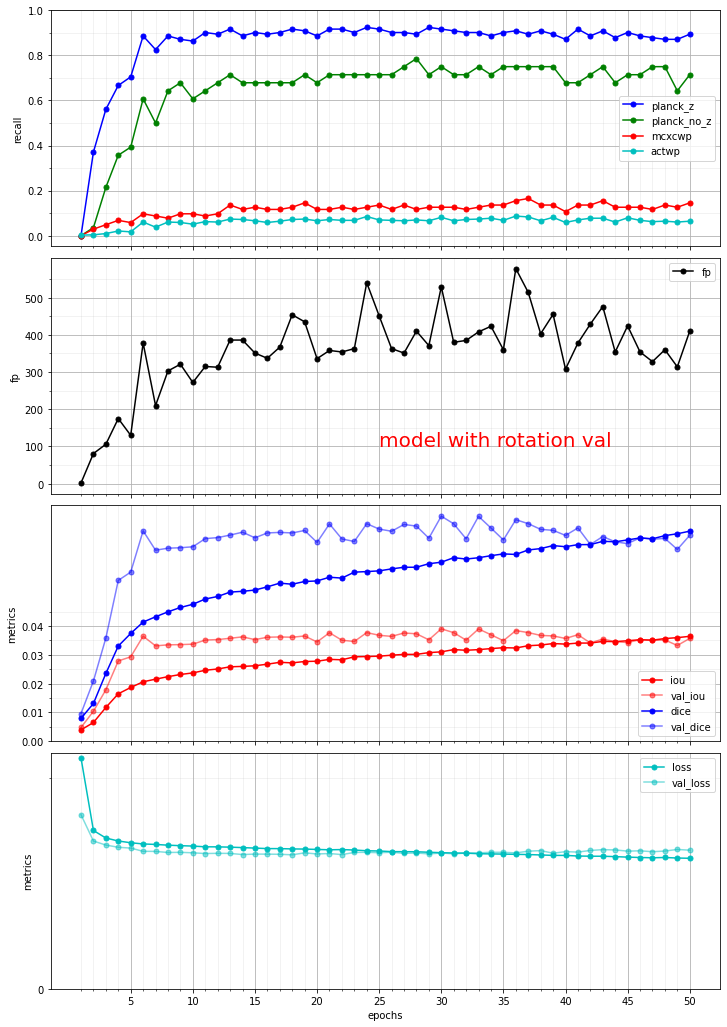

In [3]:
plot_stats_ep(stats_rot, '/home/rt2122/Data/detected_cats/act_ros_rot/tmp/act_ros_rot.ep1-50.history', 
              text='model with rotation val', text_coords=[25, 100])